In [18]:
import pandas
import matplotlib
import seaborn
import collections

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('colorblind')
seaborn.set_style('whitegrid')

In [2]:
import sys
sys.path.append('..')

from helpers import ECOSYSTEMS, DATE_RANGE, load_data, create_snapshot

In [28]:
FIG_SIZE = (6, 3)
FIG_DATE_RANGE = (pandas.to_datetime('2007-01-01'), DATE_RANGE[-1])

In [4]:
df_data = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    packages, dependencies = load_data(ecosystem)
    df_data[ecosystem] = {
        'packages': packages, 
        'dependencies': dependencies,
    }

hello
hello
hello


## Characteristics

In [5]:
df = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    # Number of packages, versions and dependencies
    df.loc[ecosystem, 'packages'] = len(data['packages'].groupby('package'))
    df.loc[ecosystem, 'releases'] = len(data['packages'])
    df.loc[ecosystem, 'dependencies'] = len(data['dependencies'])
    
    # Oldest package
    df.loc[ecosystem, 'from_date'] = data['packages']['time'].min()
    df.loc[ecosystem, 'to_date'] = data['packages']['time'].max()
    
    # Latest snapshot
    sn_packages, sn_dependencies = create_snapshot(data['packages'], data['dependencies'], df.loc[ecosystem, 'to_date'])
    df.loc[ecosystem, 'sn_packages'] = len(sn_packages.groupby('package'))
    df.loc[ecosystem, 'sn_dependencies'] = len(sn_dependencies)
    
df.T

hello
hello
hello


,cran,npm,rubygems
packages,9568,317159,122791
releases,57530,1.92775e+06,685591
dependencies,128113,7.6443e+06,1.67482e+06
from_date,1997-10-08 19:56:17,2010-11-09 23:36:08,2009-07-25 17:46:22
to_date,2016-04-26 20:52:26,2016-06-28 14:35:28.717000,2016-09-07 14:02:43.409000
sn_packages,9568,317159,122791
sn_dependencies,22191,728448,183127


## Packages, releases and dependencies over time

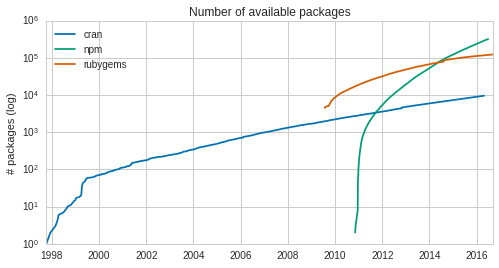

In [24]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby('package')
        [['time']]
        .min()
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of available packages',
    xlim=FIG_DATE_RANGE,
)

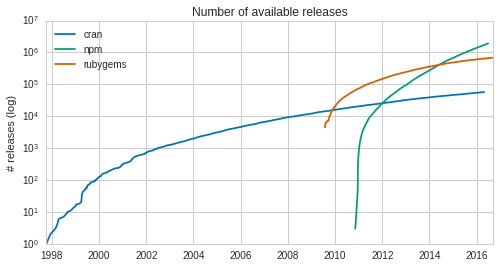

In [20]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='Number of available releases',
    xlim=FIG_DATE_RANGE,
)

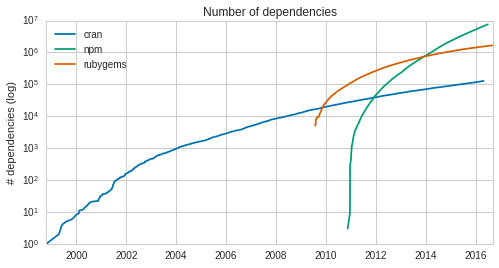

In [23]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .merge(data['dependencies'], how='right', on=['package', 'version'])
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True)

ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Number of dependencies',
    xlim=FIG_DATE_RANGE,
)

## New packages, releases and dependencies by month

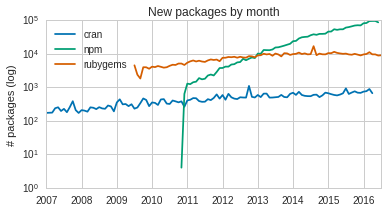

In [29]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby(['package', 'version'])
        [['time']]
        .min()
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='New packages by month',
    xlim=FIG_DATE_RANGE,
)

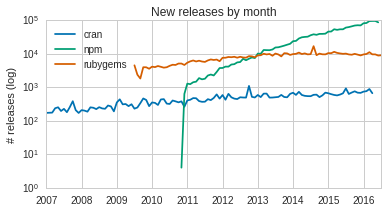

In [30]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='New releases by month',
    xlim=FIG_DATE_RANGE,
)

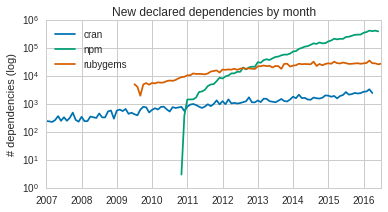

In [32]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .merge(data['dependencies'], how='right', on=['package', 'version'])
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='New dependencies by month',
    xlim=FIG_DATE_RANGE,
)

## Delay between releases

In [40]:
# Time of next release
for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .sort_values(['package', 'time'])
        .set_index(['package', 'version'])
        .assign(next_release=lambda d: d['time'].shift(-1))
    )
    index_of_last_releases = (
        df
        .groupby(level='package', sort=False)
        .tail(1)
        .index
    )
    df.loc[index_of_last_releases, 'next_release'] = pandas.NaT
    
    df_data[ecosystem]['packages'] = df.reset_index()

 (0, 18),

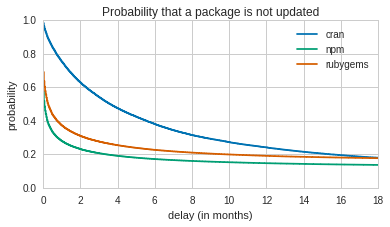

In [44]:
import lifelines
#from lifelines.statistics import logrank_test

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    kmp_df = (
        data['packages']
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Probability that a package is not updated',
    xlim=(0, 18)
)    